# Categorical and count data

In the next few lessons, we look at models for discrete rather than continuous data. These models arise when we ask whether or not something happens — for example, is an applicant given a loan or not — or when we count how often something happens — for example, how many trees are there per unit area in a forest.

## Prep plan

* The McElreath reading is long today and should take ~1½ hours.
* You will find the Python-translated code from the textbook here, as usual.
* There are a few very short exercises at the end of the workbook. Their aim is to get you thinking more deeply about link functions, which we will further discuss in class.

## The logit link function

The logit function (shown below) maps a real value in the range $(0, 1)$ to the full range of real numbers, $(-\infty, \infty)$. Note that ½ maps to 0 and that the function is strictly increasing.

**Run this cell** to see a plot of the logit function.

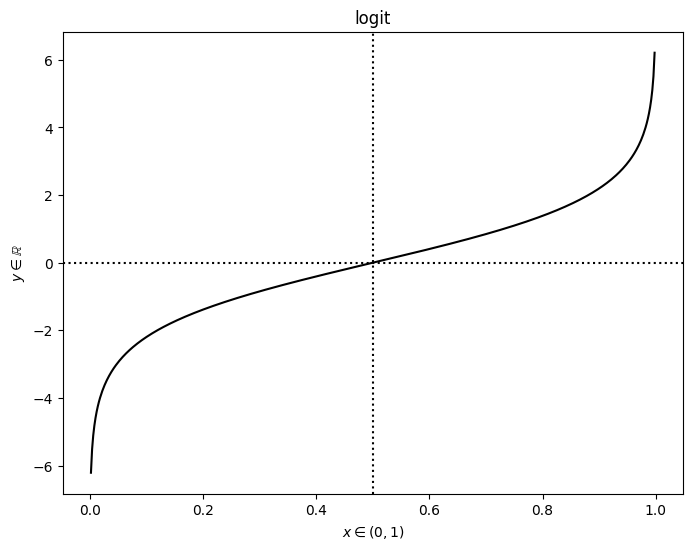

In [1]:
from scipy.special import logit  # Import from the "special" functions
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 1, 500)[1:-1]  # Exclude the values 0 and 1 since 0 maps to -oo and 1 maps to +oo.
plt.figure(figsize=(8, 6))
plt.title('logit')
plt.xlabel(r'$x \in (0,1)$')
plt.ylabel(r'$y \in \mathbb{R}$')
plt.axvline(0.5, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.plot(x, logit(x), 'k-')
plt.show()

The logit function is useful when we want to do linear regression on a probability parameter. For example, the Binomial distribution has a parameter, $p\in[0,1]$. To model $p$ using linear regression, we can map it to a real variable using $x = \text{logit}(p)$ and then model $x$ as a linear function of some predictor variables.

When PyMC generates posterior samples of the value of $x$, we can transform them to samples of $p$ using the inverse of the logit function, which is often call the _logistic_ function and sometimes called the _expit_ function. In SciPy, it is available using `from scipy.special import expit`.

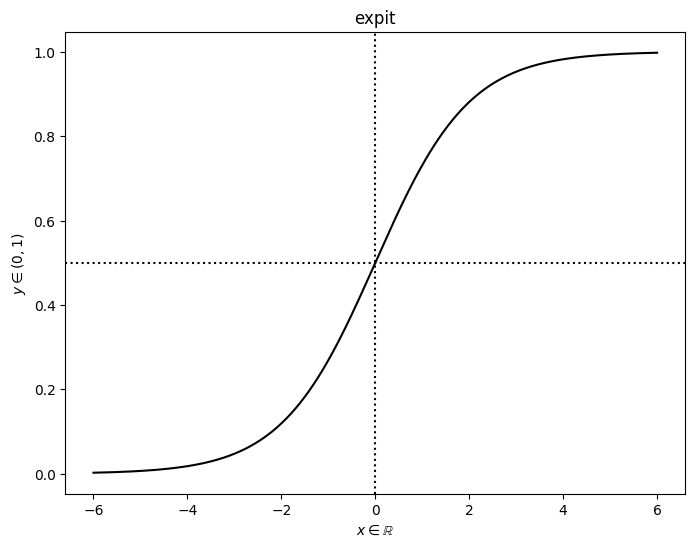

In [2]:
from scipy.special import expit

x = np.linspace(-6, 6, 500)
plt.figure(figsize=(8, 6))
plt.title('expit')
plt.xlabel(r'$x \in \mathbb{R}$')
plt.ylabel(r'$y \in (0, 1)$')
plt.axvline(0, color='black', linestyle=':')
plt.axhline(0.5, color='black', linestyle=':')
plt.plot(x, expit(x), 'k-')
plt.show()

## Required reading: Statistical rethinking

Read Section 11.1 of McElreath, R. (2020). _Statistical Rethinking, Second Edition_. Chapman and Hall/CRC Press.

* [Publisher’s page](https://www.routledge.com/Statistical-Rethinking-A-Bayesian-Course-with-Examples-in-R-and-STAN/McElreath/p/book/9780367139919) for buying the book if you want to
* [The whole book is available online on O’Reilly via the San Francisco Public Library](https://learning-oreilly-com.ezproxy.sfpl.org/library/view/statistical-rethinking-2nd/9780429639142/xhtml/19_Chapter11.xhtml). Log in with your library card number.

Outline:

* **Chapter introduction (_God spiked the integers_)** (550 words). Read this brief introduction before starting the next section. It makes the point that the priors and posteriors of models with discrete outcomes (counts and categories) can be harder to interpret than models with continuous outcomes.
* **Section 11.1 (_Binomial regression_) is required** (8,900 words). This section works through a model of binary (0/1) outcomes using real data. It goes into a lot of detail and you should follow along with all of it. If this is the first time you encounter the logit function, you might want to read the section on this topic below first. Focus on the importance of priors and checking the prior-predictive distributions before fitting your model to the data. This is an important step in the statistical modeling workflow.
  * **Section 11.1.1. _Logistic regression: Prosocial chimpanzees_.** Logistic regression is very often used for predicting 0/1 outcomes. This section introduces an experiment with chimpanzee behavior. Other examples include whether you are approved for a loan, competition win/loss outcomes, and whether a student gets a math question right or wrong. This section works through the details of doing logistic regression.
  * **Section 11.1.2. Relative shark and absolute deer.** A short but important section on relative probabilities (or risks) and absolute probabilities (or risks).
  * **Section 11.1.3. Aggregated binomial: Chimpanzees again, condensed.** Rather than modeling 0/1 outcomes individually, we can tally them up to count the number of 0 outcomes and the number of 1 outcomes. These models are very similar to what you have seen already in this section.
  * **Section 11.1.4. Aggregated binomial: Graduate school admissions.** A different, real application analyzing how we can interpret correlations correctly or incorrectly depending on which predictor variables we include in our models. This analysis is an example of [Simpson’s paradox](https://www.youtube.com/watch?v=bArPxj5xhso), which you might have encountered before.

## Code from Section 11.1

The next part of this workbook contains the R code provided in the McElreath book, translated to Python and PyMC. The code was modified and cleaned up slightly from [the source](https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_11.ipynb) (the `pymc-resources` repository). While reading Section 11.1, you need to follow along in this workbook and run the code as you go.

In [3]:
import arviz as az
import pandas as pd
import pymc as pm
import scipy.stats as sts

from scipy.special import expit as logistic

# Set the default credible interval to match the textbook
az.rcParams["stats.ci_prob"] = 0.89

RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

**Code 11.1**

In [4]:
d = pd.read_csv(
    'https://course-resources.minerva.edu/uploaded_files/mu/00273678-4926/chimpanzee.csv',
    sep=';')
# we change "actor" to zero-index
d.actor = d.actor - 1
d

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,0,NaN,0,1,2,0,1,0
1,0,NaN,0,1,4,0,0,1
2,0,NaN,0,1,6,1,0,0
3,0,NaN,0,1,8,0,1,0
4,0,NaN,0,1,10,1,1,1
...,...,...,...,...,...,...,...,...
499,6,4.0,1,6,64,1,1,1
500,6,6.0,1,6,66,1,1,1
501,6,3.0,1,6,68,0,0,1
502,6,7.0,1,6,70,0,0,1


**Code 11.2**

In [5]:
d["treatment"] = d.prosoc_left + 2 * d.condition
d[["actor", "prosoc_left", "condition", "treatment"]]

,actor,prosoc_left,condition,treatment
0,0,0,0,0
1,0,0,0,0
2,0,1,0,1
3,0,0,0,0
4,0,1,0,1
...,...,...,...,...
499,6,1,1,3
500,6,1,1,3
501,6,0,1,2
502,6,0,1,2


**Code 11.3**

In [6]:
d.groupby("treatment").first()[["prosoc_left", "condition"]]

,prosoc_left,condition
treatment,,
0,0,0
1,1,0
2,0,1
3,1,1


**Code 11.4 and 11.5**

In [7]:
with pm.Model() as m11_1:
    a = pm.Normal('a', 0.0, 10.0)
    p = pm.Deterministic('p', pm.math.invlogit(a))  # Use the inverse logit map
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    prior_11_1 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

# Create the prior pred plot:
with pm.Model() as m11_1bis:
    a = pm.Normal('a', 0.0, 1.5)
    p = pm.Deterministic('p', pm.math.invlogit(a))
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    prior_11_1bis = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

**Code 11.6**

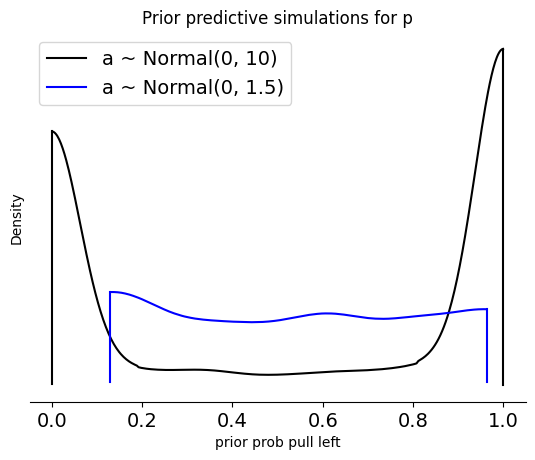

In [8]:
az.plot_density(
    [prior_11_1, prior_11_1bis],
    data_labels=["a ~ Normal(0, 10)", "a ~ Normal(0, 1.5)"],
    group="prior",
    colors=["k", "b"],
    var_names=["p"],
    point_estimate=None)
plt.xlabel("prior prob pull left")
plt.ylabel("Density")
plt.title("Prior predictive simulations for p");

**Code 11.7–11.9**

In [9]:
with pm.Model() as m11_2:
    a = pm.Normal("a", 0.0, 1.5)
    b = pm.Normal("b", 0.0, 10.0, shape=4)

    p = pm.math.invlogit(a + b[d.treatment])
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    prior_11_2 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

with pm.Model() as m11_3:
    a = pm.Normal("a", 0.0, 1.5)
    b = pm.Normal("b", 0.0, 0.5, shape=4)

    p = pm.math.invlogit(a + b[d.treatment])
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    prior_11_3 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

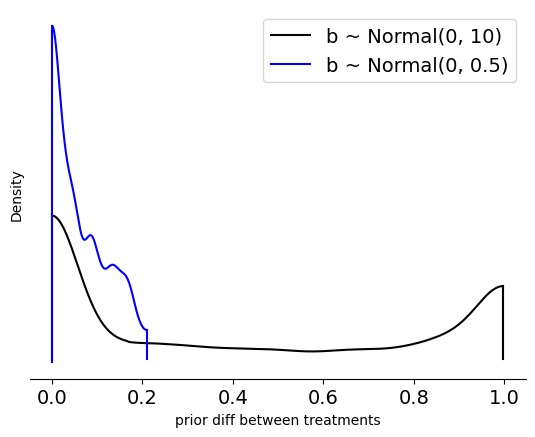

In [10]:
p_treat1, p_treat2 = (
    logistic(prior_11_2.prior["a"] + prior_11_2.prior["b"].sel(b_dim_0=0)),
    logistic(prior_11_2.prior["a"] + prior_11_2.prior["b"].sel(b_dim_0=1)),
)
p_treat1_bis, p_treat2_bis = (
    logistic(prior_11_3.prior["a"] + prior_11_3.prior["b"].sel(b_dim_0=0)),
    logistic(prior_11_3.prior["a"] + prior_11_3.prior["b"].sel(b_dim_0=1)),
)

ax = az.plot_density(
    [np.abs(p_treat1 - p_treat2).values, np.abs(p_treat1_bis - p_treat2_bis).values],
    data_labels=["b ~ Normal(0, 10)", "b ~ Normal(0, 0.5)"],
    group="prior",
    colors=["k", "b"],
    point_estimate=None,
)
plt.xlabel("prior diff between treatments")
plt.ylabel("Density")
plt.title(None);

In [11]:
np.abs(p_treat1_bis - p_treat2_bis).mean().values

array(0.09297293)

**Code 11.10**

In [12]:
actor_idx, actors = pd.factorize(d.actor)
treat_idx, treatments = pd.factorize(d.treatment)

**Code 11.11**

In [13]:
with pm.Model() as m11_4:
    a = pm.Normal('a', 0.0, 1.5, shape=len(actors))
    b = pm.Normal('b', 0.0, 0.5, shape=len(treatments))

    actor_id = pm.intX(pm.Data('actor_id', actor_idx))
    treat_id = pm.intX(pm.Data('treat_id', treat_idx))
    p = pm.Deterministic('p', pm.math.invlogit(a[actor_id] + b[treat_id]))

    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_11_4 = pm.sample(chains=4, random_seed=RANDOM_SEED)

az.summary(trace_11_4, var_names=['a', 'b'], round_to=2)

Output()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.46,0.34,-0.99,0.08,0.01,0.01,1738.33,2548.60,1.0
a[1],3.88,0.74,2.69,4.98,0.01,0.01,3681.08,2414.00,1.0
a[2],-0.76,0.33,-1.28,-0.22,0.01,0.01,1806.91,2385.05,1.0
a[3],-0.76,0.34,-1.27,-0.18,0.01,0.01,1795.68,2450.72,1.0
a[4],-0.46,0.34,-0.97,0.11,0.01,0.01,1727.58,2275.43,1.0
a[5],0.47,0.34,-0.04,1.02,0.01,0.00,1811.15,2729.68,1.0
a[6],1.95,0.42,1.29,2.63,0.01,0.01,2284.19,2389.76,1.0
b[0],-0.03,0.29,-0.51,0.41,0.01,0.00,1568.73,2512.87,1.0
b[1],0.49,0.28,0.04,0.93,0.01,0.00,1588.61,2076.97,1.0
b[2],-0.38,0.29,-0.89,0.04,0.01,0.00,1429.49,2176.30,1.0


**Code 11.12**

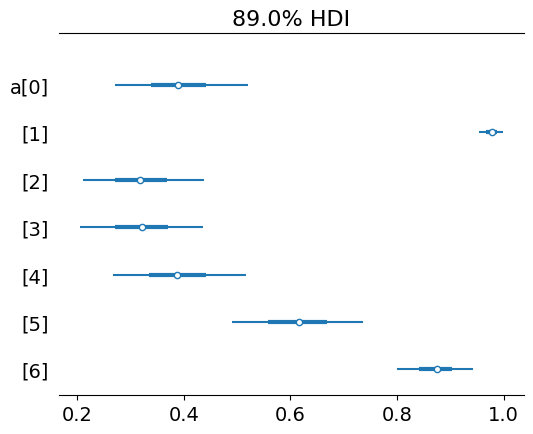

In [14]:
az.plot_forest(trace_11_4, var_names=['a'], transform=logistic, combined=True);

**Code 11.13**

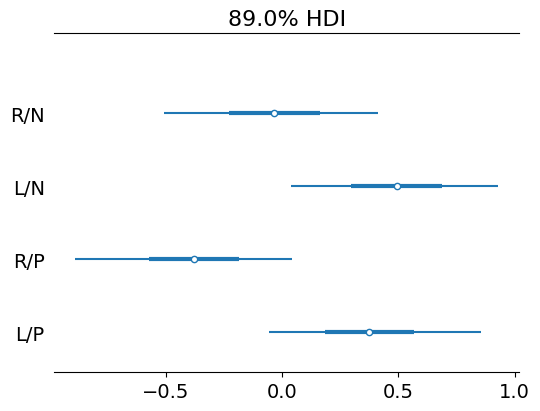

In [15]:
ax = az.plot_forest(trace_11_4, var_names=['b'], combined=True)
ax[0].set_yticklabels(['L/P', 'R/P', 'L/N', 'R/N']);

**Code 11.14**

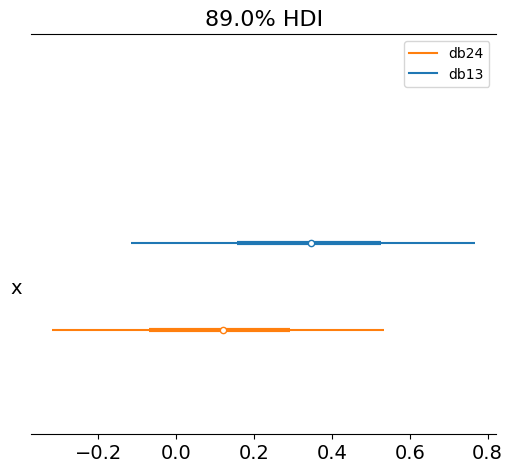

In [16]:
db13 = trace_11_4.posterior["b"].sel(b_dim_0=0) - trace_11_4.posterior["b"].sel(b_dim_0=2)
db24 = trace_11_4.posterior["b"].sel(b_dim_0=1) - trace_11_4.posterior["b"].sel(b_dim_0=3)
az.plot_forest([db13.values, db24.values], model_names=["db13", "db24"], combined=True);

**Code 11.15**

In [17]:
pl = d.groupby(["actor", "treatment"]).agg("mean")["pulled_left"].unstack()
pl

treatment,0,1,2,3
actor,,,,
0,0.333333,0.500000,0.277778,0.555556
1,1.000000,1.000000,1.000000,1.000000
2,0.277778,0.611111,0.166667,0.333333
3,0.333333,0.500000,0.111111,0.444444
4,0.333333,0.555556,0.277778,0.500000
5,0.777778,0.611111,0.555556,0.611111
6,0.777778,0.833333,0.944444,1.000000


**Code 11.16 and 11.17**

In [18]:
with m11_4:
    pm.set_data({"actor_id": np.repeat(range(7), 4), "treat_id": list(range(4)) * 7})
    p_post = pm.sample_posterior_predictive(trace_11_4, random_seed=RANDOM_SEED, var_names=["p"])
p_mu = p_post.posterior_predictive.p.mean(['chain', 'draw']).values.reshape((7, 4))

Output()

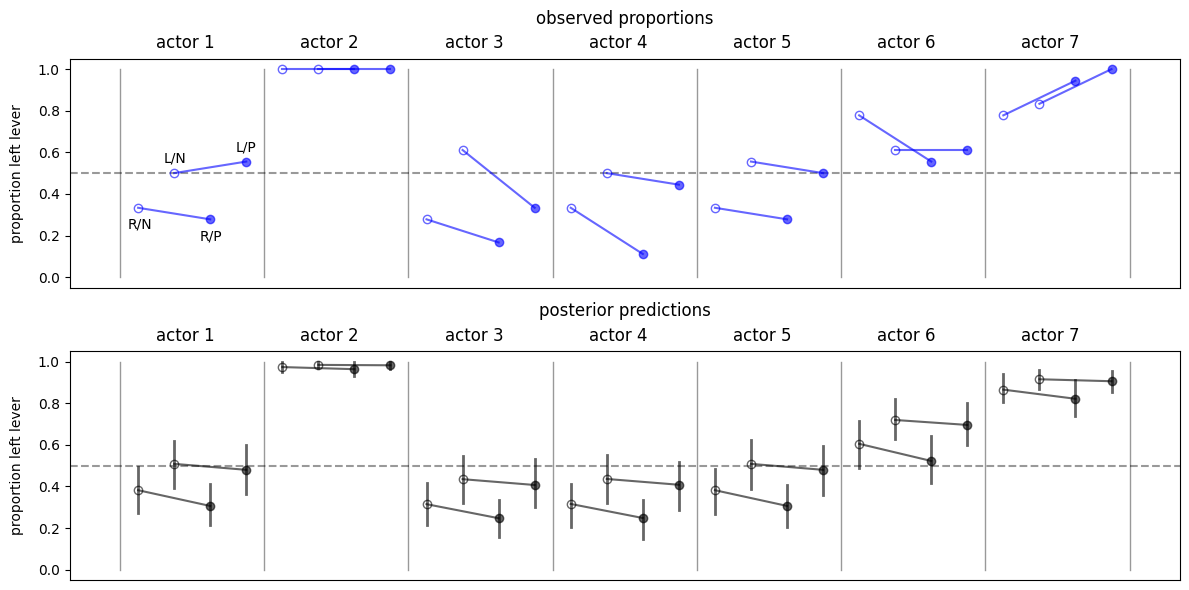

In [19]:
pl_val = pl.stack().values
_, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 6))
alpha, xoff, yoff = 0.6, 0.3, 0.05

ax0.plot([7 * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
ax0.axhline(0.5, ls="--", c="k", alpha=0.4)
for actor in range(len(actors)):
    ax0.plot(
        [actor * 4, actor * 4 + 2],
        [pl.loc[actor, 0], pl.loc[actor, 2]],
        "-",
        c="b",
        alpha=alpha,
    )
    ax0.plot(
        [actor * 4 + 1, actor * 4 + 3],
        [pl.loc[actor, 1], pl.loc[actor, 3]],
        "-",
        c="b",
        alpha=alpha,
    )
    ax0.plot(
        [actor * 4, actor * 4 + 1],
        [pl.loc[actor, 0], pl.loc[actor, 1]],
        "o",
        c="b",
        fillstyle="none",
        ms=6,
        alpha=alpha,
    )
    ax0.plot(
        [actor * 4 + 2, actor * 4 + 3],
        [pl.loc[actor, 2], pl.loc[actor, 3]],
        "o",
        c="b",
        ms=6,
        alpha=alpha,
    )
    ax0.plot([actor * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
    ax0.text(actor * 4 + 0.5, 1.1, f"actor {actor + 1}", fontsize=12)
    if actor == 0:
        ax0.text(actor * 4 - xoff, pl.loc[actor, 0] - 2 * yoff, "R/N")
        ax0.text(actor * 4 + 1 - xoff, pl.loc[actor, 1] + yoff, "L/N")
        ax0.text(actor * 4 + 2 - xoff, pl.loc[actor, 2] - 2 * yoff, "R/P")
        ax0.text(actor * 4 + 3 - xoff, pl.loc[actor, 3] + yoff, "L/P")
ax0.set_xticks([])
ax0.set_ylabel("proportion left lever", labelpad=10)
ax0.set_title("observed proportions", pad=25)

ax1.plot([range(28), range(28)], az.hdi(p_post.posterior_predictive).p.values.T, "k-", lw=2, alpha=alpha)
ax1.plot([7 * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
ax1.axhline(0.5, ls="--", c="k", alpha=0.4)
for actor in range(len(actors)):
    ax1.plot(
        [actor * 4, actor * 4 + 2],
        [p_mu[actor, 0], p_mu[actor, 2]],
        "-",
        c="k",
        alpha=alpha,
    )
    ax1.plot(
        [actor * 4 + 1, actor * 4 + 3],
        [p_mu[actor, 1], p_mu[actor, 3]],
        "-",
        c="k",
        alpha=alpha,
    )
    ax1.plot(
        [actor * 4, actor * 4 + 1],
        [p_mu[actor, 0], p_mu[actor, 1]],
        "o",
        c="k",
        fillstyle="none",
        ms=6,
        alpha=alpha,
    )
    ax1.plot(
        [actor * 4 + 2, actor * 4 + 3],
        [p_mu[actor, 2], p_mu[actor, 3]],
        "o",
        c="k",
        ms=6,
        alpha=alpha,
    )
    ax1.plot([actor * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
    ax1.text(actor * 4 + 0.5, 1.1, f"actor {actor + 1}", fontsize=12)
ax1.set_xticks([])
ax1.set_ylabel("proportion left lever", labelpad=10)
ax1.set_title("posterior predictions", pad=25)
plt.tight_layout();

**Code 11.18**

In [20]:
side = d.prosoc_left.values  # right 0, left 1
cond = d.condition.values  # no partner 0, partner 1

**Code 11.19**

In [21]:
with pm.Model() as m11_5:
    a = pm.Normal("a", 0.0, 1.5, shape=len(actors))
    bs = pm.Normal("bs", 0.0, 0.5, shape=2)
    bc = pm.Normal("bc", 0.0, 0.5, shape=2)

    p = pm.math.invlogit(a[actor_idx] + bs[side] + bc[cond])

    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    trace_11_5 = pm.sample(chains=4, random_seed=RANDOM_SEED)
    pm.compute_log_likelihood(trace_11_5)

Output()

Output()

**Code 11.20**

As we changed the data of `m11_4` above, we need to sample from it again, with the original data:

In [22]:
with m11_4:
    pm.set_data({"actor_id": actor_idx, "treat_id": treat_idx})
    trace_11_4 = pm.sample(chains=4, random_seed=RANDOM_SEED)
    pm.compute_log_likelihood(trace_11_4)

az.compare({"m11_4": trace_11_4, "m11_5": trace_11_5}, scale='deviance')
# TOFIX: Why are the weights here 1.0 and 0.0 but in the textbook they are 0.68 and 0.32?

Output()

Output()

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m11_5,0,530.774115,7.752513,0.000000,1.0,19.084962,0.000000,False,deviance
m11_4,1,532.471303,8.617452,1.697188,0.0,18.955838,1.248288,False,deviance


**Code 11.23**

In [23]:
np.exp(trace_11_4.posterior.b.values[:, :, 3] - trace_11_4.posterior.b.values[:, :, 1]).mean().round(3)

np.float64(0.923)

**Code 11.24**

In [24]:
d = pd.read_csv(
    'https://course-resources.minerva.edu/uploaded_files/mu/00273678-4926/chimpanzee.csv',
    sep=';')
d.actor = d.actor - 1
d["treatment"] = d.prosoc_left + 2 * d.condition

d_aggregated = (
    d.groupby(["treatment", "actor"]).sum().reset_index()[["treatment", "actor", "pulled_left"]]
)
d_aggregated.head(10)

,treatment,actor,pulled_left
0,0,0,6
1,0,1,18
2,0,2,5
3,0,3,6
4,0,4,6
5,0,5,14
6,0,6,14
7,1,0,9
8,1,1,18
9,1,2,11


**Code 11.25**

In [25]:
with pm.Model() as m11_6:
    a = pm.Normal("a", 0.0, 1.5, shape=len(actors))
    b = pm.Normal("b", 0.0, 0.5, shape=len(treatments))

    p = pm.Deterministic("p", pm.math.invlogit(a[d_aggregated.actor] + b[d_aggregated.treatment]))

    pulled_left = pm.Binomial("pulled_left", 18, p, observed=d_aggregated.pulled_left)

    trace_11_6 = pm.sample(chains=4, random_seed=RANDOM_SEED)
    pm.compute_log_likelihood(trace_11_6)

Output()

Output()

**Code 11.26**

ArviZ won't even let you compare models with different observations:

In [27]:
az.compare({"m11_4": trace_11_4, "m11_6": trace_11_6}, scale='deviance')

ValueError: The number of observations should be the same across all models

**Code 11.27**

In [28]:
# deviance of aggregated 6-in-9
(-2 * sts.binom.logpmf(6, 9, 0.2)).round(5)

np.float64(11.79048)

In [29]:
# deviance of dis-aggregated
-2 * sts.bernoulli.logpmf([1, 1, 1, 1, 1, 1, 0, 0, 0], 0.2).sum().round(5)

np.float64(20.65212)

**Code 11.28**

In [30]:
d_ad = pd.read_csv(
    "https://course-resources.minerva.edu/uploaded_files/mu/00273679-5172/ucbadmit.csv",
    sep=";")
d_ad

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375
9,E,male,53,138,191
10,E,female,94,299,393


**Code 11.29**

In [31]:
gid = (d_ad["applicant.gender"] == "female").astype(int).values

with pm.Model() as m11_7:
    a = pm.Normal("a", 0, 1.5, shape=2)
    p = pm.Deterministic("p", pm.math.invlogit(a[gid]))

    admit = pm.Binomial("admit", p=p, n=d_ad.applications, observed=d_ad.admit)

    trace_11_7 = pm.sample(chains=4, random_seed=RANDOM_SEED)
az.summary(trace_11_7, var_names=["a"], round_to=2)

Output()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.22,0.04,-0.28,-0.16,0.0,0.0,3978.44,2669.72,1.0
a[1],-0.83,0.05,-0.91,-0.75,0.0,0.0,3944.87,3085.55,1.0


**Code 11.30**

In [32]:
diff_a = (
    trace_11_7.posterior.a.values[:, :, 0] -
    trace_11_7.posterior.a.values[:, :, 1])
diff_p = (
    logistic(trace_11_7.posterior.a.values[:, :, 0]) -
    logistic(trace_11_7.posterior.a.values[:, :, 1]))
az.summary({"diff_a": diff_a, "diff_p": diff_p}, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
diff_a,0.61,0.06,0.51,0.71
diff_p,0.14,0.01,0.12,0.16


**Code 11.31**

In [33]:
with m11_7:
    ppc = pm.sample_posterior_predictive(
        trace_11_7, random_seed=RANDOM_SEED, var_names=["admit"])
pp_admit = ppc.posterior_predictive.admit / d_ad.applications.values[None, :]

Output()

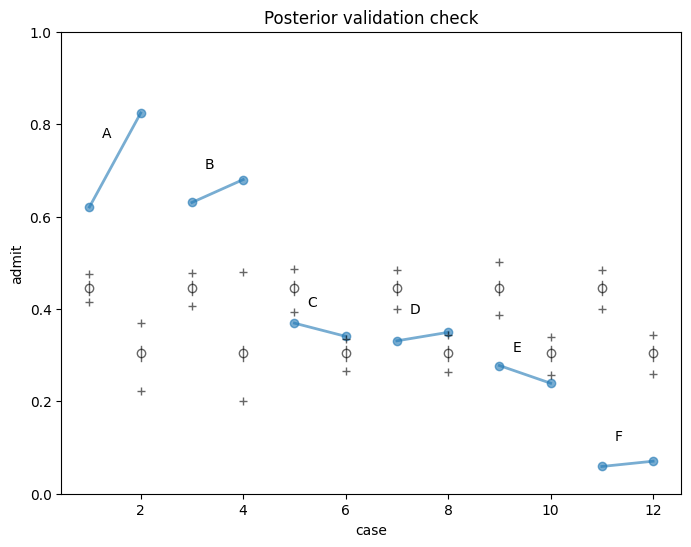

In [34]:
plt.figure(figsize=(8, 6))

for i in range(6):
    x = 1 + 2 * i

    y1 = d_ad.admit[x] / d_ad.applications[x]
    y2 = d_ad.admit[x + 1] / d_ad.applications[x + 1]

    plt.plot([x, x + 1], [y1, y2], "-C0o", alpha=0.6, lw=2)
    plt.text(x + 0.25, (y1 + y2) / 2 + 0.05, d_ad.dept[x])

plt.plot(range(1, 13), trace_11_7.posterior.p.values.mean((0, 1)), "ko", fillstyle="none", ms=6, alpha=0.6)
plt.plot([range(1, 13), range(1, 13)], az.hdi(trace_11_7.posterior).p.values.T, "k-", lw=1, alpha=0.6)
plt.plot([range(1, 13), range(1, 13)], az.hdi(pp_admit).admit.values.T, "k+", ms=6, alpha=0.6)

plt.xlabel("case")
plt.ylabel("admit")
plt.title("Posterior validation check")
plt.ylim(0, 1);

**Code 11.32**

In [35]:
dept_id = pd.Categorical(d_ad["dept"]).codes

with pm.Model() as m11_8:
    a = pm.Normal("a", 0, 1.5, shape=2)
    delta = pm.Normal("delta", 0, 1.5, shape=6)

    p = pm.math.invlogit(a[gid] + delta[dept_id])

    admit = pm.Binomial("admit", p=p, n=d_ad.applications, observed=d_ad.admit)

    trace_11_8 = pm.sample(chains=4, random_seed=RANDOM_SEED)

az.summary(trace_11_8, round_to=2)

Output()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.51,0.52,-1.42,0.23,0.03,0.02,428.29,465.52,1.02
a[1],-0.42,0.52,-1.26,0.39,0.02,0.02,430.99,491.40,1.02
delta[0],1.09,0.52,0.34,2.00,0.03,0.02,433.05,513.73,1.02
delta[1],1.05,0.53,0.17,1.86,0.03,0.02,437.81,509.21,1.02
delta[2],-0.16,0.52,-0.98,0.67,0.03,0.02,434.13,464.14,1.02
delta[3],-0.20,0.52,-1.02,0.64,0.03,0.02,433.43,512.98,1.02
delta[4],-0.64,0.52,-1.45,0.22,0.02,0.02,434.01,509.43,1.02
delta[5],-2.20,0.54,-3.08,-1.37,0.03,0.02,444.84,642.74,1.02


**Code 11.33**

In [36]:
diff_a = (
    trace_11_8.posterior.a.values[:, :, 0] -
    trace_11_8.posterior.a.values[:, :, 1])
diff_p = (
    logistic(trace_11_8.posterior.a.values[:, :, 0]) -
    logistic(trace_11_8.posterior.a.values[:, :, 1]))
az.summary({"diff_a": diff_a, "diff_p": diff_p}, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
diff_a,-0.10,0.08,-0.22,0.03
diff_p,-0.02,0.02,-0.05,0.01


**Code 11.34**

In [37]:
pg = pd.DataFrame(index=["male", "female"], columns=d_ad.dept.unique())
for dep in pg.columns:
    pg[dep] = (
        d_ad.loc[d_ad.dept == dep, "applications"]
        / d_ad.loc[d_ad.dept == dep, "applications"].sum()
    ).values
pg.round(2)

,A,B,C,D,E,F
male,0.88,0.96,0.35,0.53,0.33,0.52
female,0.12,0.04,0.65,0.47,0.67,0.48


## Exercises

### McElreath Exercise 11E1

If an event has probability 0.35, what are the log odds of this event?

In [42]:
import math
odds_1 = 0.35/(1-0.35)
log_odds_1 = math.log(odds_1)
log_odds_1

-0.6190392084062235

### McElreath Exercise 11E2

If an event has log-odds 3.2, what is the probability of this event?

In [51]:
from sympy import solve
from sympy.abc import p
log_odds_2 = 3.2
odds_2 = math.exp(log_odds_2)
solve([p/(1-p) - odds_2], p)

{p: 0.960834277203236}

### McElreath Exercise 11E3

Suppose that a coefficient in a logistic regression has value 1.7. What does this imply about the proportional change in the _odds_ (not log odds) of the outcome?

In [ ]:
# ENTER YOUR ANSWER IN FORUM

### Link functions 1

Why would a log (not logit) link function be inappropriate for Binomial linear regression? Explain the important differences between the log and logit functions in this respect.

In [ ]:
# ENTER YOUR ANSWER IN FORUM

### Link functions 2

Find another function (not logit) that could be appropriate for Binomial linear regression. Explain why your function is appropriate.

In [ ]:
# ENTER YOUR ANSWER IN FORUM